# Previsão de Demanda – Modelagem

Esse é o notebook onde vou construir o modelo de previsão de vendas para o Grupo Boticário. A ideia é criar uma solução prática, que funcione bem e ajude no planejamento da demanda.

Aqui vou mostrar as etapas que segui, que incluem:

1. Definição do problema  
2. Preparação dos dados  
3. Pipeline de Modelagem  
4. Treinamento e Validação 
5. Otimização de Hiperparâmetros 
6. Teste final
7. Conclusão Final

-------------

## 1. Definição do Problema

Neste projeto, o objetivo é construir um modelo para **prever as vendas dos próximos ciclos de tempo**, com foco em apoiar a tomada de decisão do time de planejamento.

Imagine o seguinte cenário: estamos no ciclo **2020-11**, e o time precisa se preparar para o próximo ciclo (**2020-12**). Essa previsão é essencial para organizar **produção, distribuição e estoque**, especialmente considerando que os ciclos anteriores impactam diretamente os seguintes.

Mas vamos além: além de prever apenas o **próximo ciclo (curto prazo)**, também vamos testar o modelo em uma previsão mais desafiadora, até o ciclo **2021-01** (**longo prazo**). Isso nos permitirá avaliar como o modelo se comporta em diferentes horizontes temporais

Como temos milhares de produtos com vendas em escalas muito diferentes, vou transformar a variável alvo (y) usando o logaritmo. Dessa forma, o modelo foca em prever o percentual de erro e não é dominado pelos produtos que vendem mais.

Para medir o desempenho, vou acompanhar métricas como:

- Log MAE  
- RMSE  
- MAPE  
- R²

E também analisar a distribuição do MAPE para entender onde o modelo acerta ou erra mais.

-----------

## 2. Preparação dos Dados

### 2.1 Importanto bibliotecas

In [26]:
from datetime import datetime

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_percentage_error,
    r2_score,
    median_absolute_error
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    OneHotEncoder,
    OrdinalEncoder
)

import xgboost as xgb
from xgboost import plot_importance

import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization

#

### 2.2 Carregamento dos dados

In [27]:
df = pd.read_csv('dataset.csv', sep=';', decimal=',')

df.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO
0,201917,1,431148,anon_S0,anon_S2,anon_S3,anon_S1,11934.0,414.0,431869.08,431869.08,0,0,0,0,0,NaN,455.4
1,202005,0,177816,anon_S0,anon_S2,anon_S4,anon_S1,540.0,252.0,27743.40,27743.40,0,0,0,0,0,NaN,773.4
2,201901,0,171786,anon_S0,anon_S5,anon_S6,anon_S1,54012.0,1410.0,962860.20,962860.20,0,1,0,0,0,35.0,341.4
3,201813,0,177774,anon_S7,anon_S2,anon_S8,anon_S1,438.0,NaN,7608.60,7608.60,0,0,0,0,0,NaN,450.9
4,202006,1,446592,anon_S0,anon_S5,anon_S9,anon_S1,2760.0,240.0,83339.40,83339.40,0,0,0,0,0,NaN,431.4


#

### 2.3 Análise inicial dos dados

Outras análises exploratórias já foram feitas anteriormente. Aqui, vou mostrar apenas o que é realmente necessário para a modelagem.

#### Distribuição da variável alvo (y)

Vou apresentar a distribuição da variável y (vendas) para mostrar como os valores estão em escalas muito diferentes, reforçando a necessidade da transformação logarítmica que usei depois no modelo.

In [28]:
df['QT_VENDA_BRUTO'].describe()

count    1.739230e+05
mean     1.050377e+04
std      3.327551e+04
min      2.345454e+02
25%      3.960000e+02
50%      2.070000e+03
75%      8.634000e+03
max      1.865862e+06
Name: QT_VENDA_BRUTO, dtype: float64

Observa que a média está puxada para cima, muito influenciada por poucos produtos com vendas extremamente altas. Isso indica uma distribuição assimétrica, onde a média não é uma boa referência para o "típico" valor.

É mais confiável trabalhar com métricas que consideram o erro percentual, e também aplicar transformações como o log na variável alvo para equilibrar essa diferença.

#

### 2.4 Ajustando dados incorretos


Levando em consideração a análise feita no ponto 2.2 do arquivo 01_analise_exploratoria, foi necessário corrigir um valor incorreto na variável preço.

In [29]:
df['VL_PRECO'] = df['VL_RECEITA_BRUTA']/((df['QT_VENDA_BRUTO']))

#

### 2.5 Divisão dos dados para treino e teste

Aqui separamos os dados considerando a ordem temporal dos ciclos. Usamos os dados até o ciclo 2020-12 para treinar o modelo e os ciclos maiores ou iguais a 202012 para testar.

Essa divisão respeita a sequência natural do tempo, simulando a situação real em que queremos prever vendas futuras com base no histórico disponível.

In [30]:
df_test = df[df['COD_CICLO'] >= 202012]

df = df[df['COD_CICLO'] < 202012]

df_test['COD_CICLO'].unique()

array([202017, 202015, 202012, 202014, 202013, 202016, 202101])

#

### 2.6 Variáveis vazadas

Durante a análise dos dados, identifiquei algumas variáveis que contêm informações do futuro (vazamento de dados) e que, se usadas, poderiam deixar o modelo com desempenho irrealista.

As variáveis vazadas que não serão utilizadas são:

- `QT_DEVOLUCAO` — contém informações sobre devoluções que só são conhecidas após a venda.  
- `VL_RECEITA_BRUTA` — representa receita total futura, não disponível no momento da previsão.  
- `VL_RECEITA_LIQUIDA` — receita líquida futura, também só conhecida depois do evento.

**Observação:**  
Estamos levando em consideração que as variáveis de **preço** e **marketing** são definidas antes.  
Por isso, elas podem ser usadas no modelo sem risco de vazamento, já que o objetivo aqui é prever a **quantidade vendida** com base nas condições já planejadas.


#

### 2.7 Divisão dos dados (treino e validação)  

Separando os dados para realizar o treinamento e validação


In [31]:
X = df.drop(columns='QT_VENDA_BRUTO')
y = df['QT_VENDA_BRUTO'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, 
                                                    y,test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True)

------------

## 3. Pipeline de Modelagem

Agora começa a parte de modelagem. A ideia aqui é deixar tudo pronto para o modelo: separar os tipos de variáveis, aplicar os tratamentos certos e garantir que o processo seja reproduzível com o uso de pipelines.

#

### 3.1 Lista de variáveis por tipo

Aqui eu separo as variáveis que vão ser tratadas de forma diferente na pipeline:

In [32]:
lista_ordinal = ['COD_CICLO']

lista_categorica = ['COD_MATERIAL', 'COD_CANAL','DES_CATEGORIA_MATERIAL', 
                    'DES_MARCA_MATERIAL', 'COD_REGIAO']

lista_continua_1 = ['VL_PRECO']

lista_continua_2 = ['PCT_DESCONTO']

lista_flag = ['FLG_DATA', 'FLG_CAMPANHA_MKT_A','FLG_CAMPANHA_MKT_B',
              'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E']

#

### 3.2 Preparação e transformadores

Aqui defino os tratamentos para cada tipo de variável. No caso das categóricas, como precisam de duas etapas (imputação e codificação), criei um pipeline específico — não dá pra fazer isso direto no ColumnTransformer.

Também criei uma função auxiliar para extrair o ano e o ciclo da coluna COD_CICLO.

In [33]:
def split_cod_ciclo(X):
    X = X.copy()
    X['ANO'] = X['COD_CICLO'].astype(str).str.zfill(6).str[:4].astype(int)
    X['CICLO'] = X['COD_CICLO'].astype(str).str.zfill(6).str[4:].astype(int)
    
    return X[['ANO', 'CICLO']]

split = FunctionTransformer(split_cod_ciclo)

In [34]:
ordinal = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1, dtype=int)

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', ordinal)])

#

### 3.3 Criação dos transformadores (ColumnTransformer)

Aqui monto o ColumnTransformer para aplicar o tratamento certo em cada tipo de variável:

- COD_CICLO é transformado com a função que separa ano e ciclo;

- variáveis categóricas passam pelo pipeline de imputação e codificação;

- variáveis numéricas têm imputação adequada (mediana ou zero);

- variáveis flag são preenchidas pela moda.

Isso deixa o pré-processamento organizado, consistente e facilita o uso depois no modelo. O resultado é um DataFrame, o que ajuda na análise.

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', split, lista_ordinal),
        ('categorica', categorical_pipeline, lista_categorica),
        ('continua_1', SimpleImputer(strategy='median'), lista_continua_1),
        ('continua_2', SimpleImputer(strategy='constant', fill_value=0), lista_continua_2),
        ('flag', SimpleImputer(strategy='most_frequent'), lista_flag)
    ],verbose_feature_names_out=False
)
preprocessor.set_output(transform='pandas')
preprocessor.fit(X_train, y_train)
preprocessor.transform(X_train)

,ANO,CICLO,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,VL_PRECO,PCT_DESCONTO,FLG_DATA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E
27983,2018,15,1365,1,5,9,0,21.282500,0.0,0,0,0,0,0,0
50025,2020,8,2086,0,5,20,0,1.372500,0.0,1,1,0,0,0,0
110845,2018,14,1536,1,1,26,1,37.283846,0.0,0,0,0,0,0,0
76310,2018,8,1000,0,5,25,0,15.686111,0.0,0,0,0,0,0,0
31526,2020,3,1603,1,3,0,0,14.031852,0.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140198,2019,6,91,1,4,36,1,1.797500,0.0,1,0,0,0,0,0
121228,2020,3,1578,1,3,76,1,29.491616,0.0,0,0,0,0,0,0
154276,2020,6,1463,0,1,11,0,14.186667,0.0,1,0,0,0,0,0
171796,2019,13,1500,0,0,7,0,15.501887,0.0,0,0,0,0,0,0


#

### 3.4 Escolha do modelo base

Escolhi o XGBoost como modelo inicial, pois já usei ele e outros algoritmos como Random Forest em projetos de previsão anteriores, e geralmente funcionam bem. Testei ambos, mas o XGBoost entregou o melhor resultado, por isso segui com ele.

**Observação**: o modelo já está com alguns hiperparâmetros definidos, mas vou mostrar mais detalhes sobre isso na etapa de ajuste.

In [36]:
xgb = xgb.XGBRegressor(
    learning_rate=0.08,
    max_depth=20,
    subsample=0.8,
    reg_lambda=10,
    alpha=4,
    n_estimators=1200,
    random_state=42,
    n_jobs=-1
)

#

### 3.5 Pipeline completa
Aqui junto o pré-processamento com o modelo em um pipeline único, garantindo organização e replicabilidade.

In [37]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb)
])

pipeline

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('ordinal', ...), ('categorica', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


#

### 3.6 Usando o TransformedTargetRegressor  

O TransformedTargetRegressor aplica uma transformação (neste caso, log) na variável alvo antes de começar a pipeline e reverte automaticamente essa transformação nas previsões, facilitando o trabalho com escalas muito diferentes.

In [38]:
def log_transform(y):
    return np.log(y)

def inverse_log_transform(y):
    return np.exp(y)

model = TransformedTargetRegressor(
    regressor=pipeline,
    func=log_transform,
    inverse_func=inverse_log_transform)

model

,regressor,"Pipeline(step...bs=-1, ...))])"
,transformer,None
,func,<function log...0018709C3A8E0>
,inverse_func,<function inv...0018709C3AE80>
,check_inverse,True
,transformers,"[('ordinal', ...), ('categorica', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


Com o modelo final construído, agora vamos partir para o treinamento e validação para avaliar seu desempenho.

-----

## 4.  Treinamento e Validação

Nesta etapa, vou treinar o modelo, validar sua performance com validação cruzada, avaliar os resultados na base de validação e analisar a importância das features. As métricas que acompanho são MAE LOG, MAPE, MedAE e R², sendo o MAPE a principal métrica, pois mede o erro percentual, que é o mais relevante para previsão de demanda.

### 4.1 Treinamento do Modelo

Treino o modelo utilizando a pipeline completa nos dados de treino.

In [39]:
model.fit(X_train, y_train)

,regressor,"Pipeline(step...bs=-1, ...))])"
,transformer,None
,func,<function log...0018709C3A8E0>
,inverse_func,<function inv...0018709C3AE80>
,check_inverse,True
,transformers,"[('ordinal', ...), ('categorica', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False


#

### 4.2 Validação Cruzada

Avalio o modelo com validação cruzada para garantir robustez na performance.

In [40]:
cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')

array([-0.25042948, -0.23496154, -0.24644604, -0.2498451 , -0.24825792])

#

### 4.3 Avaliação com Dados de Validação

Utilizo os dados reservados para validação para verificar o desempenho final do modelo nas métricas MAE LOG, MAPE, MedAE e R². Destaco o MAPE como métrica principal, pois queremos minimizar o erro percentual nas previsões.

Para entender melhor os valores do MAPE, aplico o método describe() para analisar sua distribuição e interpretar o desempenho do modelo.

In [41]:
def avaliar_regressao(y_true, y_pred):
    mae_log_value = mean_squared_log_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    resultado = (
        f"\n  Avaliação feita em: {datetime.now()}\n\n"
        f"MAE LOG  (MAE em escala logarítmica):        {mae_log_value:.4f}\n"
        f"MAPE     (Mean Absolute Percentage Error):   {mape:.4f}\n"
        f"MedAE    (Median Absolute Error):            {medae:.4f}\n"
        f"R²       (R-squared):                        {r2:.4f}\n"
        f"{'-'*60}"
    )

    print(resultado)

y_pred = model.predict(X_val)

metricas = avaliar_regressao(y_val, y_pred)

print(f"\nMediana dos valores de validação: {y_val.median()}")


  Avaliação feita em: 2025-07-02 19:46:30.955000

MAE LOG  (MAE em escala logarítmica):        0.1121
MAPE     (Mean Absolute Percentage Error):   0.2204
MedAE    (Median Absolute Error):            267.7482
R²       (R-squared):                        0.7309
------------------------------------------------------------

Mediana dos valores de validação: 1992.0


In [42]:
pd.DataFrame({'MAPE (%)': abs((y_val - y_pred) / y_val) * 100}).describe()

,MAPE (%)
count,14868.000000
mean,22.035530
std,42.666372
min,0.000375
25%,2.850841
50%,10.993094
75%,26.763772
max,1280.546580


#

### 4.4 Análise da Importância das Features

Analiso quais variáveis tiveram maior impacto nas previsões do modelo para ajudar a entender o que ele está priorizando.

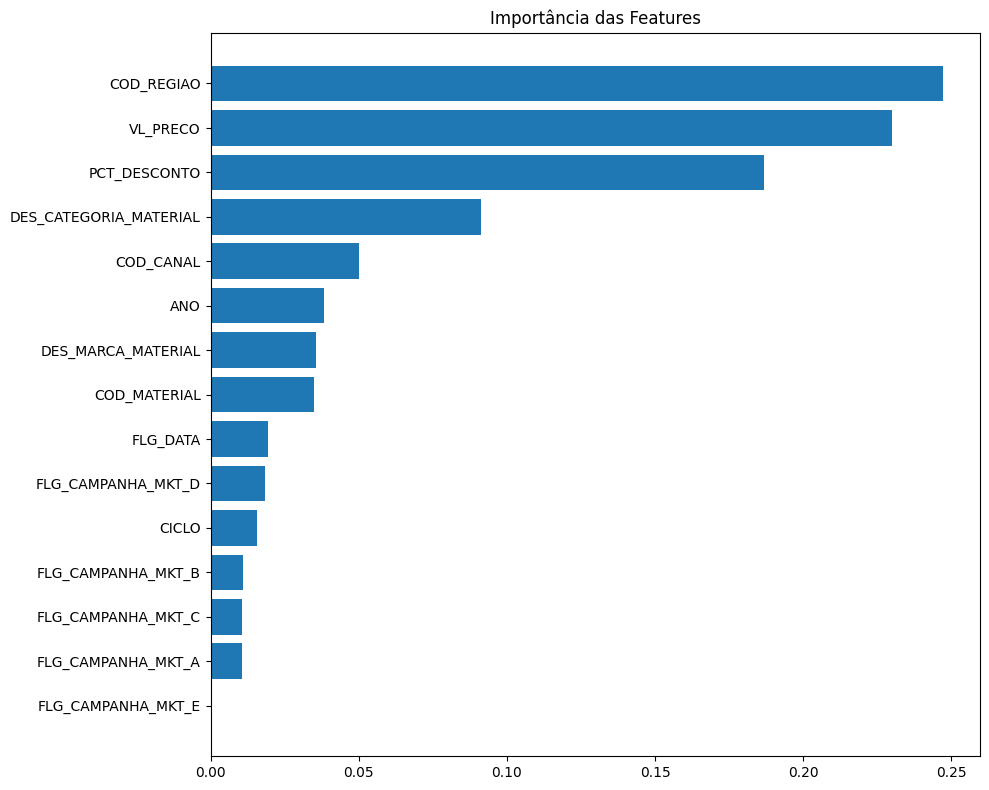

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Pegando os nomes das features do preprocessor dentro da pipeline
feature_names = preprocessor.transform(X_train).columns

# Pegando a importância das features do regressor (XGBoost)
importancia = model.regressor_.named_steps['model'].feature_importances_

# Plot simples
indices = np.argsort(importancia)
plt.figure(figsize=(10, 8))
plt.barh(range(len(importancia)), importancia[indices[::-1]])
plt.yticks(range(len(importancia)), np.array(feature_names)[indices[::-1]])
plt.title('Importância das Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#

-------

## 5. Otimização de Hiperparâmetros

Aqui faço a busca dos melhores valores para os hiperparâmetros do XGBoost usando otimização bayesiana. Os parâmetros ajustados são:

- learning_rate (taxa de aprendizado)

- max_depth (profundidade máxima da árvore)

- subsample (amostragem dos dados por árvore)

- reg_lambda (regularização L2)

- alpha (regularização L1)

- n_estimators (número de árvores)

O objetivo é encontrar a combinação que minimize o erro médio absoluto via validação cruzada.

In [44]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error


def pipeline_cv(learning_rate, gamma, max_depth, subsample, reg_lambda, alpha, n_estimators):
    
    model = xgb.XGBRegressor(
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        subsample=subsample,
        reg_lambda=reg_lambda,
        alpha=alpha,
        n_estimators=int(n_estimators),
        random_state=42,
        n_jobs=-1
    )

    pipe = Pipeline([
        ("preprocessor", preprocessor),  # substitua pelo seu ColumnTransformer
        ("model", model)
    ])

    model = TransformedTargetRegressor(
    regressor=pipe,
    func=log_transform,
    inverse_func=inverse_log_transform)

    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')
    
    return scores.mean()

pbound = {
    "learning_rate": (0.01, 0.15),         
    "gamma": (0, 5),                     
    "max_depth": (5, 20),
    "subsample": (0.6, 0.9),                
    "reg_lambda": (0, 10),                
    "alpha": (0, 10),
    "n_estimators": (1000, 1500)         
}

bo = BayesianOptimization(
    f=pipeline_cv,
    pbounds=pbound,
    verbose=2,
    random_state=42
)

#bo.maximize(init_points=50, n_iter=100)

#

------

## 6. Teste Final

Vamos agora testar o modelo com dois tipos de previsão:  
- **Curto prazo**, para o próximo ciclo (2020-12)  
- **Longo prazo**, para todos os ciclos até 2021-01  

Isso permite avaliar o desempenho do modelo em diferentes horizontes de tempo.

## 6.1 Curto prazo

### 6.1.1 Previsão do ciclo futuro

Aqui usamos os dados do ciclo 202012 que ainda não temos para prever as vendas.

In [45]:
df_test_curto = df_test[df_test['COD_CICLO']==202012]

X_test_curto = df_test_curto.drop(columns='QT_VENDA_BRUTO')
y_test_curto = df_test_curto['QT_VENDA_BRUTO'].astype(int)

y_pred_real_curto = model.predict(X_test_curto)

#

### 6.1.2 Avaliação dos resultados

Comparamos as previsões com os valores reais (quando disponíveis) e avaliamos o desempenho do modelo.

In [46]:
metricas = avaliar_regressao(y_test_curto, y_pred_real_curto)

print(f"\nMediana dos valores de teste: {y_test_curto.median()}")


  Avaliação feita em: 2025-07-02 19:46:31.913195

MAE LOG  (MAE em escala logarítmica):        0.2198
MAPE     (Mean Absolute Percentage Error):   0.3218
MedAE    (Median Absolute Error):            498.1877
R²       (R-squared):                        0.4693
------------------------------------------------------------

Mediana dos valores de teste: 2484.0


Antes de finalizar, quero fazer mais uma validação rápida: analisar a distribuição do erro percentual (MAPE) para entender melhor como o modelo se comporta em diferentes situações, não só olhando a média geral.

In [47]:
pd.DataFrame({'MAPE (%)': abs((y_test_curto - y_pred_real_curto) / y_test_curto) * 100}).describe()

,MAPE (%)
count,3541.000000
mean,32.177891
std,54.633753
min,0.002612
25%,5.534517
50%,17.992815
75%,41.607965
max,1411.027465


Analisando essa distribuição, vemos que o erro percentual médio é de cerca de 32%, mas a presença de valores muito altos acaba puxando essa média para cima, como mostra o alto desvio padrão. Por outro lado, ao olhar os quartis, percebemos que 75% dos nossos dados têm erro percentual menor que 41%, o que sugere um modelo pode dar um boa previsão para maior parte dos dados.

----

## 6.2 Longo prazo

### 6.2.1 Previsão dos ciclos futuros

Aqui usamos os dados dos ciclos que ainda não temos para prever as vendas de longo prazo.

In [48]:
X_test_longo = df_test.drop(columns='QT_VENDA_BRUTO')
y_test_longo = df_test['QT_VENDA_BRUTO'].astype(int)

y_pred_real_longo = model.predict(X_test_longo)

### 6.2.2 Avaliação dos resultados

Comparamos as previsões com os valores reais (quando disponíveis) e avaliamos o desempenho do modelo.

In [49]:
metricas = avaliar_regressao(y_test_longo, y_pred_real_longo)

print(f"\nMediana dos valores de teste: {y_test_longo.median()}")


  Avaliação feita em: 2025-07-02 19:46:32.700625

MAE LOG  (MAE em escala logarítmica):        0.4989
MAPE     (Mean Absolute Percentage Error):   0.5588
MedAE    (Median Absolute Error):            879.5791
R²       (R-squared):                        0.3708
------------------------------------------------------------

Mediana dos valores de teste: 2940.0


Antes de finalizar, quero fazer mais uma validação rápida: analisar a distribuição do erro percentual (MAPE) para entender melhor como o modelo se comporta em diferentes situações, não só olhando a média geral.

In [50]:
pd.DataFrame({'MAPE (%)': abs((y_test_longo - y_pred_real_longo) / y_test_longo) * 100}).describe()

,MAPE (%)
count,25249.000000
mean,55.882492
std,167.776565
min,0.000083
25%,7.544132
50%,26.418541
75%,57.362952
max,9015.426366


Analisando essa distribuição, vemos que o erro percentual médio é de cerca de 55%, mas a presença de valores muito altos acaba puxando essa média para cima, como mostra o alto desvio padrão. Por outro lado, ao olhar os quartis, percebemos que 75% dos nossos dados têm erro percentual menor que 57%, o que sugere um modelo pode dar um boa previsão para maior parte dos dados.

----

## 7. Conclusão

### Desempenho na Validação (base histórica)

- O modelo apresentou **bom desempenho durante a validação**, com:
  - MAPE de **22,04%**
  - 50% dos casos com erro percentual abaixo de **10,99%**
  - 75% dos casos com erro abaixo de **26,76%**

> Isso indica que, durante o treino, o modelo conseguiu aprender padrões relevantes e foi eficiente para prever os ciclos dentro da base histórica.

---

### Desempenho no Curto Prazo (próximo ciclo real)

- Ao prever o ciclo seguinte com dados reais fora do treino, houve **queda de desempenho**:
  - MAPE subiu para **32,18%**
  - 50% dos erros abaixo de **18%**
  - R² caiu para **46,93%**

> O modelo ainda entrega uma previsão razoável, mas já mostra perda de estabilidade, sugerindo que nem toda a variação dos dados reais está sendo capturada.

---

### Desempenho no Longo Prazo (previsão até 2021-01)

- Em cenários de médio a longo prazo, o erro aumentou consideravelmente:
  - MAPE alcançou **55,88%**
  - 50% dos erros abaixo de **28%**
  - R² caiu para **37,08%**

> A precisão caiu de forma significativa, evidenciando que o modelo **não é confiável para prever ciclos muito à frente**, e que há **fatores relevantes que o modelo não está captando**.

---

### Conclusão Geral

- O modelo é **eficiente para previsões de curto prazo**, especialmente para o **próximo ciclo**.

- **Não deve ser utilizado para prever dois ou mais ciclos à frente**, pois o erro se acumula rapidamente e a performance se deteriora.

- A **queda do R² para menos de 50%** é um alerta de que **as variáveis atuais não explicam bem o comportamento futuro dos dados**.

- Uma **limitação importante** é a ausência de variáveis com **informação temporal explícita** (ex: data, mês, feriado), que permitiriam gerar variáveis derivadas via *feature engineering*.

- A **melhor estratégia prática** é retreinar o modelo a cada novo ciclo, aproveitando os dados mais recentes — que tendem a refletir melhor a realidade atual.

- Esse retreinamento pode ser facilmente **automatizado com ferramentas como Docker**, garantindo que o modelo se mantenha atualizado e confiável ao longo do tempo.
